# Importing Libraries

In [1]:
import torch

import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

from collections import Counter

import shutil
import random

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, ConcatDataset

import torchvision.models as models
import timm 

import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR

c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
train_dataset_path = 'Dataset/Train'
test_dataset_path = 'Dataset/Test'
train_augmented_dataset_path = 'Dataset/Augmented'

Combined training dataset has 9249 images.
Label counts in combined training dataset: Counter({'Normal': 1787, 'Blast': 1392, 'BacterialBlight': 1269, 'SheathBlight': 1201, 'BacterialLeafBlight': 1200, 'BacterialLeafStreak': 1200, 'BrownSpot': 1200})


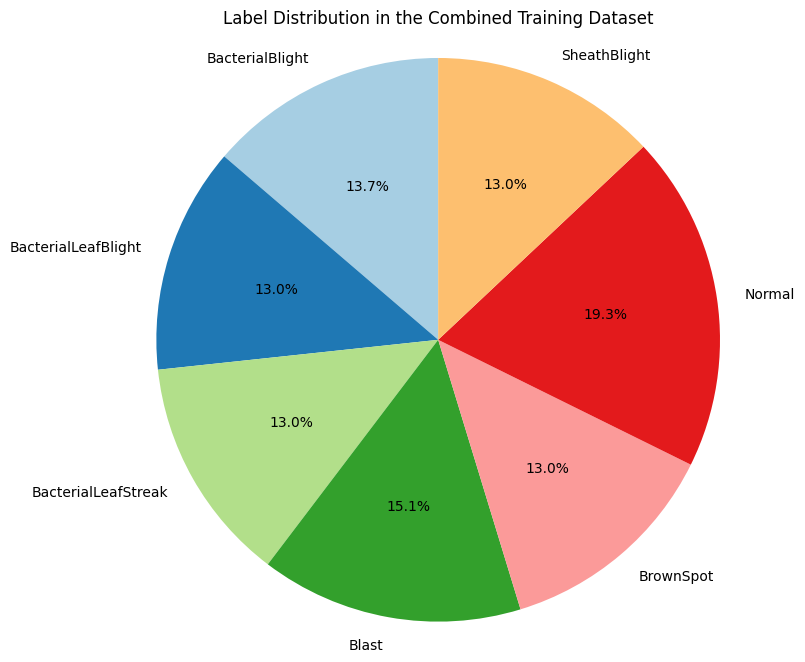

In [3]:
# Define paths
train_augmented_path = 'Dataset/Augmented'
train_dataset_path = 'Dataset/Train'
test_dataset_path = 'Dataset/Test'

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Define transformations for validation data (test data)
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
])

# Load the original training dataset
train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transforms)

# Load the augmented dataset (if any)
augmented_dataset = datasets.ImageFolder(train_augmented_path, transform=train_transforms)

# Combine the original and augmented training datasets
combined_train_dataset = ConcatDataset([train_dataset, augmented_dataset])
print(f"Combined training dataset has {len(combined_train_dataset)} images.")

# Load the test dataset
test_dataset = datasets.ImageFolder(test_dataset_path, transform=test_transforms)

# Function to count the labels in the dataset
def count_labels(dataset):
    class_to_idx = dataset.datasets[0].class_to_idx if isinstance(dataset, ConcatDataset) else dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    label_count = Counter()

    # Count each label in the combined dataset
    for dataset_part in dataset.datasets if isinstance(dataset, ConcatDataset) else [dataset]:
        for _, label in dataset_part.samples:
            label_name = idx_to_class[label]
            label_count[label_name] += 1

    return label_count

# Count the labels in the combined training dataset
label_counts = count_labels(combined_train_dataset)
print(f"Label counts in combined training dataset: {label_counts}")

# Plotting pie chart of label distribution
def plot_pie_chart(label_counts):
    labels = label_counts.keys()
    sizes = label_counts.values()

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title('Label Distribution in the Combined Training Dataset')
    plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
    plt.show()

# Plot pie chart for label distribution
plot_pie_chart(label_counts)

# Training

In [4]:
# Initialize models
models_dict = {
    'ResNet-50': models.resnet50(pretrained=True),
    # 'DenseNet-121': models.densenet121(pretrained=True),
    # 'SE-ResNet-50': timm.create_model('seresnet50', pretrained=True),
    # 'ResNeXt-50': timm.create_model('resnext50_32x4d', pretrained=True),
    # 'ResNeSt-50': timm.create_model('resnest50d', pretrained=True),
}

# Modify the final layer for each model to match the number of classes
num_classes = len(train_dataset.classes)
for model_name, model in models_dict.items():
    if hasattr(model, 'fc'):  # Check if the model has 'fc'
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif hasattr(model, 'classifier'):  # Check if the model has 'classifier'
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} does not have a known final layer.")

c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [6]:
# Define training parameters
batch_size = 32
num_workers = 8
max_epochs = 10
initial_lr = 0.001
momentum = 0.9

# Create data loaders
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Optimizer and scheduler
def get_optimizer_and_scheduler(model, warmup_epochs=2):
    # Stochastic Gradient Descent (SGD) optimizer with momentum
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum)

    # Warm-up scheduler (increases LR linearly for the first few epochs)
    def warmup_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 1.0
    
    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
    
    # Cosine Annealing Scheduler (decays LR according to cosine function)
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

    return optimizer, warmup_scheduler, cosine_scheduler

# Loss function (cross entropy for classification)
criterion = nn.CrossEntropyLoss()

# Function to train one epoch
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    return avg_loss

# Function to evaluate the model
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Training loop for all models
def train_models(models_dict, train_loader, val_loader, num_epochs, device):
    history = {}
    for model_name, model in models_dict.items():
        print(f"Training {model_name}...")

        model = model.to(device)
        optimizer, warmup_scheduler, cosine_scheduler = get_optimizer_and_scheduler(model)
        best_accuracy = 0.0
        model_history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(num_epochs):
            # Warm-up phase for the first few epochs
            if epoch < 2:
                warmup_scheduler.step()

            # Train the model for one epoch
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

            model_history['train_loss'].append(train_loss)
            model_history['val_loss'].append(val_loss)
            model_history['val_accuracy'].append(val_accuracy)

            # Update learning rate with cosine annealing after warmup
            if epoch >= 2:
                cosine_scheduler.step()

            # Save the model if it achieves the best validation accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(model.state_dict(), f'second_{model_name}.pth')

            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        history[model_name] = model_history
    return history

def plot_training_history(history):
    for model_name, metrics in history.items():
        epochs = range(1, len(metrics['train_loss']) + 1)
        
        plt.figure(figsize=(12, 4))

        # Plotting Training and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, metrics['train_loss'], label='Training Loss')
        plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy', color='green')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'{model_name}_training_plot.png')  # Save each plot as an image file
        plt.show()

In [8]:
history = train_models(models_dict, train_loader, test_loader, num_epochs=max_epochs, device=device)

Training ResNet-50...


c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch [1/10] - Train Loss: 0.9442, Val Loss: 0.4177, Val Accuracy: 0.8540
Epoch [2/10] - Train Loss: 0.3268, Val Loss: 0.1970, Val Accuracy: 0.9333
Epoch [3/10] - Train Loss: 0.1548, Val Loss: 0.0974, Val Accuracy: 0.9705
Epoch [4/10] - Train Loss: 0.0957, Val Loss: 0.0974, Val Accuracy: 0.9636
Epoch [5/10] - Train Loss: 0.0675, Val Loss: 0.0712, Val Accuracy: 0.9766
Epoch [6/10] - Train Loss: 0.0508, Val Loss: 0.0748, Val Accuracy: 0.9749
Epoch [7/10] - Train Loss: 0.0391, Val Loss: 0.0596, Val Accuracy: 0.9827
Epoch [8/10] - Train Loss: 0.0353, Val Loss: 0.0468, Val Accuracy: 0.9857
Epoch [9/10] - Train Loss: 0.0259, Val Loss: 0.0541, Val Accuracy: 0.9840
Epoch [10/10] - Train Loss: 0.0264, Val Loss: 0.0598, Val Accuracy: 0.9814


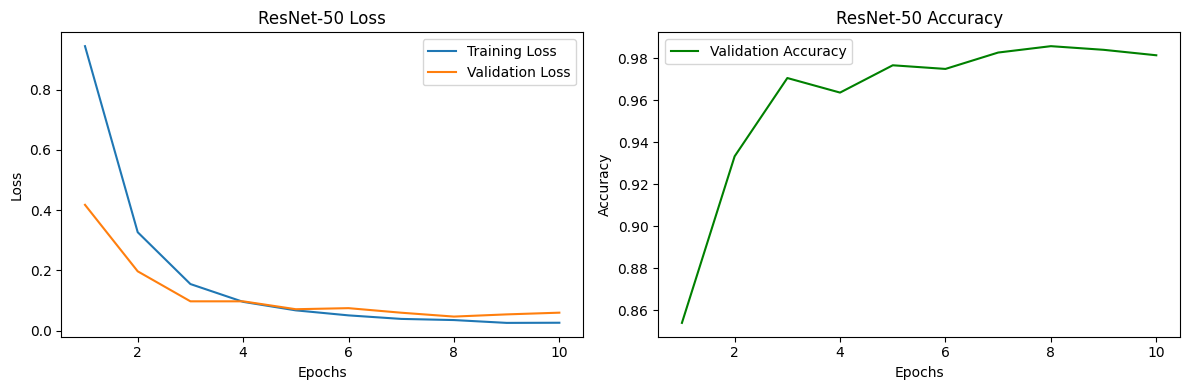

In [9]:
plot_training_history(history)